# 👉👈 Clickhouse и аналитика.

## 👨🏻‍💻 Упр. - Структуры данных и хранение
#### 🤹
Файл docker-compose.yml

![](../images/01_02.png)<br>

```
version: '3.8'
services:
  clickhouse:
    image: clickhouse/clickhouse-server:latest
    volumes:
      - clickhouse_data:/var/lib/clickhouse

    ports:
      - "8123:8123"  # HTTP интерфейс
      - "9000:9000"  # Native интерфейс
    environment:
      - CLICKHOUSE_USER=default
      - CLICKHOUSE_PASSWORD=your_password
      - CLICKHOUSE_DB=default
volumes:
  clickhouse_data:
```
#### 🤹 
Поднимаем docker-compose и заходим в контейнер
![](../images/01_03.png)<br>
![](../images/01_04.png)<br>

#### 🤹
Запускаю встроенный клиент Clickhouse

![](../images/01_05.png)<br>

#### 🤹
Создаю таблицу. Выбираю MergeTree как основной движок, потому что он поддерживает первичные ключи. В качестве первичного ключа логично взять UserID.
![](../images/01_06.png)<br>

#### 🤹
Заполняю таблицу данными
![](../images/01_07.png)<br>

проверим - данных мало - выберем все поля и строки в таблице
![](../images/01_08.png)<br>

#### 🤹Выполняю запросы:

Количество пользователей и средняя длина имени
![](../images/01_09.png)<br>

Количество регистраций по месяцам
![](../images/01_10.png)<br>

## 👨🏻‍💻 Упр. - Обработка и анализ данных

Добавьте несколько записей в созданную вами таблицу пользователей.

#### 🤹
Добавляю еще несколько пользователей
![](../images/01_11.png)<br>
#### 🤹
Напишите запрос, который выводит количество зарегистрированных пользователей за каждый месяц.

Количество зарегистрированных пользователей по месяцам
![](../images/01_12.png)<br>

Для начала добавим еще пользователей, которые зарегистрированы более года назад.

![](../images/01_13.png)<br>

при добавлении ошибочно id пользователей указан дублирующий уже имеющиеся. Все строки записаны
![](../images/01_14.png)<br>


Напишите запрос, который находит пользователей, зарегистрированных более года назад.
![](../images/01_15.png)<br>

## 👨🏻‍💻 Упр. Упр. - Интеграция и расширенные возможности

Изучите документацию ClickHouse для выбранного вами инструмента визуализации и подключитесь к созданной вами базе данных.
Создайте простой отчет, визуализирующий данные из вашей таблицы.
Изучите возможности репликации данных в ClickHouse и настройте реплицированную таблицу.

#### 🤹

Загрузим данные в dataframe pandas. Для подключения будем использовать библиотеку clickhouse_connect.

In [2]:
pip install clickhouse_connect

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import clickhouse_connect
import pandas as pd

# Подключение к ClickHouse
client = clickhouse_connect.get_client(host='localhost', 
                                       port=8123, 
                                       username='default', 
                                       password='your_password')

Создадим простой отчет, визуализирующий данные из нашей таблицы - количество регистраций по годам.

In [ ]:

# Запрос для получения количества регистраций по годам
query = ("SELECT toYear(RegistrationDate) AS year, COUNT(*) AS cnt "
         "FROM users "
         "GROUP BY year "
         "ORDER BY year")

# Выгружаем данные в DataFrame
df = client.query_df(query)
df

,year,cnt
0,2020,1
1,2023,1
2,2024,1
3,2025,8


Визуализируем столбчатой диаграммой.

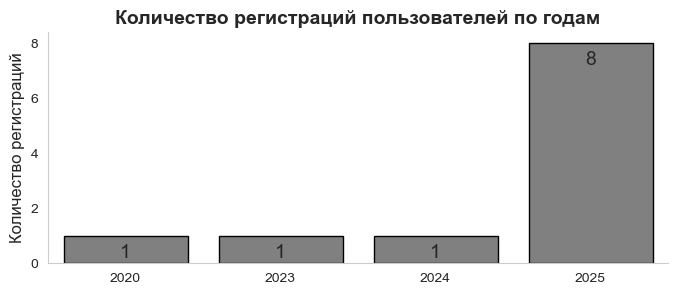

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Визуализация: столбчатая диаграмма количества регистраций по годам
sns.set_style("whitegrid")
plt.figure(figsize=(8, 3))

splot = sns.barplot(x='year', 
            y='cnt', 
            data=df,
            edgecolor='black',
            color='grey')
#добавляем подписи к столбцам со значением   
for p in splot.patches: 
    splot.annotate(format(round(p.get_height(), 3), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   size=14, 
                   xytext=(0, -12), 
                   textcoords='offset points')
    
plt.xlabel("")#"Год", fontsize=12)
plt.ylabel("Количество регистраций", fontsize=12)
plt.title("Количество регистраций пользователей по годам", 
          fontsize=14, fontweight="bold")
plt.grid(False)#axis='y')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#уберем правую и верхнюю границы из визуализации данных
sns.despine()
plt.show()


#### 🤹 Изучите возможности репликации данных в ClickHouse и настройте реплицированную таблицу.

Создание реплицированной таблицы (требует дополнительной установки ZooKeeper):

Изучены возможности репликации данных в Clickhouse
Основные шаги:

Требуется ZooKeeper
Таблицы создаются с движком ReplicatedMergeTree
Путь и имя реплики указываются вручную

Пример создания реплицируемой таблицы

```
CREATE TABLE replicated_users ON CLUSTER my_cluster
(
    UserID UInt32,
    Name String,
    Email String,
    RegistrationDate DateTime
)
ENGINE = ReplicatedMergeTree(
    '/clickhouse/tables/{shard}/replicated_users',
    '{replica}'
)
PRIMARY KEY UserID;

```

 - /clickhouse/tables/{shard}/replicated_users — путь в ZooKeeper.
 - {replica} — имя реплики (например, replica1, replica2).
 - Используется в распределенной инсталляции с указанием кластера ON CLUSTER my_cluster

